First import the following libraries:

In [20]:
import numpy as np
import math as m
from scipy import linalg
from scipy.sparse import diags
from mpl_toolkits import mplot3d
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp

Now we will use the upwind finite differences method in order to numerically solve the dynamical system described below:
<br>
<br>
$$\frac{\partial}{\partial t}y(x,t) - \alpha \frac{\partial^2}{\partial x^2}y(x,t) + \beta \frac{\partial}{\partial x}y(x,t) = 0, x \in (0,1), t \in (0, T)$$
$$y(0,t) = u(t)$$
$$\frac{\partial}{\partial x}y(1,t) = 0$$
$$y(x,0) = y_0(x)$$
<br>
With an output $z(t) = \int_0^1 y(x,t) dx$.
<br>
<br>
Set paramters to the following:
<br>
<br>
$$\alpha = 0.01, \quad \beta = 1, \quad T = 0.5$$
$$n_x = 100, \quad (h = 1/100)$$

In [21]:
#Parameters

ALPHA = .01
BETA = 1
T = .5 # time interval
DELTA = .01 # delta x, positional step size
NX = int(1/DELTA) # number of increments

Upwind finite discretization leads to:
<br>
<br>
$$\frac{d}{dt}y(t) = Ay(t) + b u(t), \quad t \in (0, T), \quad y(0) = y_0$$
<br>
where $A = \alpha A^{\text{diff}} + \beta A^{\text{conv}} \in \mathbb{R}^{n_x \times n_x}$ with  
<br>
<br>
$$A^{\text{diff}} = \frac{1}{h^2} \begin{bmatrix} -2&1&&&\\1&-2&1&&\\&\ddots&\ddots&\ddots&\\&&1&-2&1\\&&&2&-2\end{bmatrix}, A^{\text{conv}} = \frac{1}{h} \begin{bmatrix} -1&&&&\\1&-1&&&\\&\ddots&\ddots&&\\&&1&-1&\\&&&1&-1\end{bmatrix},$$

$$b = \Big(\frac{\alpha}{h^2} + \frac{\beta}{h},0,\dots,0\Big)^T \in \mathbb{R}^{n_x},$$
and
<br>
$$y_0 = \Big(y_0(x_1,t), \dots, y_0(x_{n_x},t)\Big)^T \in \mathbb{R}^{n_x}$$
<br>
<br>
Using the composite trapezoidal rule:
<br>
<br>
$$z(t) = \int_0^1 y(x,t)dx \approx c^T y(t) + d u(t)$$
<br>
with $c=(h, \dots, h, h/2)^T \in \mathbb{R}^{n_x}$ and $d=h/2$.

In [22]:
# Build matrix A and vectors b,c, and d

A_diff = (1. / DELTA**2) * diags([np.ones((NX - 1)), -2 * np.ones((NX)), np.ones((NX - 1))], [-1, 0, 1]).toarray()
A_conv = (1. / DELTA) * diags([np.ones((NX - 1)), -1 * np.ones((NX))], [-1, 0]).toarray()
A = ALPHA * A_diff + BETA * A_conv

b = np.zeros((NX, 1))
b[0] = ALPHA / DELTA**2 + BETA / DELTA

c = np.ones((NX , 1)) * DELTA
c[-1] = DELTA / 2

d = DELTA / 2

Let $y_0(x) = 0$ and $u(t) = sin(2 \pi t)$. Solve the full ODE:

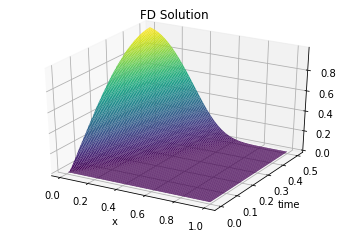

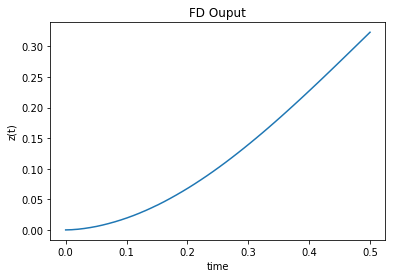

In [23]:
NT = 100

xs = np.linspace(0, 1, NX + 1)
ts = np.linspace(0, T, NT)

y0 = np.zeros((NX))

us = []
for t in ts:
    us.append(np.sin(2 * np.pi * t))
us = np.asarray(us)

def func(t, y):
    return A @ y + np.reshape(b, ((NX))) * us[int(t * (NT - 1))]

sol = solve_ivp(func, (0, T), y0, t_eval = ts)

[x,t] = np.meshgrid(xs[1:], ts)
fig = plt.figure()
ax = plt.axes(projection='3d')
ax.plot_surface(x, t, np.transpose(sol.y), rstride=1, cstride=1,cmap='viridis',edgecolor='none')
plt.xlabel('x')
plt.ylabel('time')
plt.title('FD Solution')
plt.show()

Z = np.transpose(c) @ sol.y + d * us
plt.plot(ts, np.reshape(Z, ((NT))))
plt.xlabel('time')
plt.ylabel('z(t)')
plt.title('FD Ouput')
plt.show()

Taking the Laplace transform of the dynamical system yields:
<br>
<br>
$$sY(s)-y(0)=sY(s)=AY(s) + bU(s)$$
$$Z(s) = c^T Y(s) + d U(s)$$
<br>
Solving for $Z(s)$ yields:
<br>
<br>
$$Z(s) = (c^T (sI-A)^{-1}b + d) U(s)$$
<br>
Therefore, the transfer function is:
<br>
<br>
$$H(s) = c^T (sI-A)^{-1}b + d$$
<br>
Plot the transfer function at various logarithmically spaced imaginary numbers:

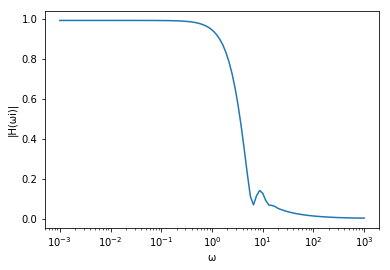

In [24]:
def H_func(s):
    return (np.transpose(c) @ linalg.solve(s * 1j * np.eye(NX) - A, b) + d)[0][0]
    
H = []    
sigmas = np.logspace(-3, 3, 100)
for sigma in sigmas:
    H.append(abs(H_func(sigma)))
H = np.asarray(H)

plt.semilogx(sigmas, H)
plt.xlabel('\u03C9')
plt.ylabel('|H(\u03C9i)|')
plt.show()

Given a set of training frequencies $\{\sigma_1, \dots, \sigma_r\}$ along the imaginary axis, create a ROM of the transfer function such that $H(\sigma_i) = \widehat{H}(\sigma_i), \quad \forall i = 1, \dots, r$. Define th ROM as the following:
<br>
<br>
$$\widehat{H}(s) = \widehat{c}^T (s\widehat{I}-\widehat{A})^{-1}\widehat{b} + \widehat{d}$$
<br>
where 
<br>
<br>
$$\widehat{I} = W_r^T I V_r, \quad \widehat{A} = W_r^T A V_r, \quad \widehat{b} = W_r^T b, \quad \widehat{c}^T = c^T V_r, \quad \widehat{d} = d$$
<br>
with 
<br>
<br>
$$V_r = \mathcal{R} \Big( \left[(\sigma_1 I - A)^{-1}b, \dots, (\sigma_r I - A)^{-1}b\right] \Big) \in \mathbb{R}^{n_x \times i}$$ 
<br>
$$W_r = \mathcal{R} \Big( \left[(\sigma_1 I - A^T)^{-1}c^T, \dots, (\sigma_r I - A^T)^{-1}c^T\right] \Big) \in \mathbb{R}^{n_x \times i}$$

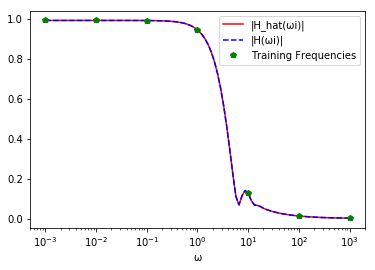

In [42]:
r = 7
sigmas_train = np.logspace(-3, 3, r)

Vr = np.zeros((NX, r), dtype=complex)
Wr = np.zeros((NX, r), dtype=complex)

idx = 0
for sigma in sigmas_train:
    Vr[:, idx] = np.reshape(linalg.solve(sigma * 1j * np.eye((NX)) - A, b), ((NX)))
    Wr[:, idx] = np.reshape(linalg.solve(sigma * 1j * np.eye((NX)) - np.transpose(A), c), ((NX)))
    idx += 1

def get_real_range(X):
    result = np.zeros((X.shape[0], X.shape[1] * 2))
    result[:, :X.shape[1]] = np.real(X)
    result[:, X.shape[1]:] = np.imag(X)
    return result

Vr = get_real_range(Vr)
Wr = get_real_range(Wr)

u_v, s_v, v_v = linalg.svd(Vr)
u_w, s_w, v_w = linalg.svd(Wr)

eps = np.finfo(float).eps
i = 0
while (s_w[i] / s_w[0] > eps or s_v[i] / s_v[0] > eps) and i < s_v.shape[0] - 1:
    i += 1
    
Vr = u_v[:, :i]
Wr = u_w[:, :i]

WrT = np.transpose(Wr)

I_hat = WrT @ np.eye((NX)) @ Vr
A_hat = WrT @ A @ Vr
b_hat = WrT @ b
c_hat = np.transpose(np.transpose(c) @ Vr)
d_hat = d

def H_hat_func(s):
    return (np.transpose(c_hat) @ linalg.solve(s * 1j * I_hat - A_hat, b_hat) + d_hat)[0][0]

H_hat = []    
for sigma in sigmas:
    H_hat.append(abs(H_hat_func(sigma)))
H_hat = np.asarray(H_hat)

H_hat_train = []
for sigma in sigmas_train:
    H_hat_train.append(abs(H_hat_func(sigma)))
H_hat_train = np.asarray(H_hat_train)

plt.semilogx(sigmas, H_hat, color = 'red', label = '|H_hat(\u03C9i)|')
plt.semilogx(sigmas, H, color = 'blue', label = '|H(\u03C9i)|', linestyle = '--')
plt.semilogx(sigmas_train, H_hat_train, marker = 'p', color = 'green', 
             linestyle = 'None', label = 'Training Frequencies')
plt.xlabel('\u03C9')
plt.legend()
plt.show()

Solve for $z(t)$ using the ROM and compare the results with $z(t)$ generated from the FD method:

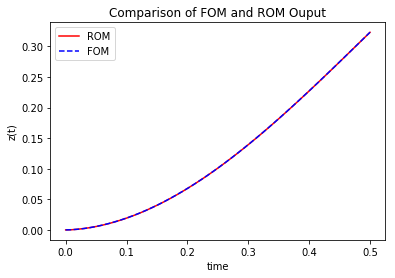

In [45]:
def func_hat(t, y):
    return linalg.inv(I_hat) @ A_hat @ y + linalg.inv(I_hat) @ np.reshape(b_hat, ((i))) * us[int(t * (NT - 1))]

y0_hat = np.zeros((i))
rom_sol = solve_ivp(func_hat, (0, T), y0_hat, t_eval = ts)

rom_Z = np.transpose(c_hat) @ rom_sol.y + d_hat * us
plt.plot(ts, np.reshape(rom_Z, ((NT))), label = 'ROM', color = 'red')
plt.plot(ts, np.reshape(Z, ((NT))), label = 'FOM', linestyle = '--', color = 'blue')
plt.xlabel('time')
plt.ylabel('z(t)')
plt.title('Comparison of FOM and ROM Ouput')
plt.legend()
plt.show()